<a href="https://colab.research.google.com/github/Arshad221b/Sign-Language-Recognition/blob/master/sign_language_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import torch 
import torch.nn as nn 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from tqdm import tqdm

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! kaggle datasets download -d datamunge/sign-language-mnist

In [ ]:
! unzip /content/sign-language-mnist.zip

In [9]:
train = pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')

In [ ]:
train.head(5)

In [11]:
X = train.drop(['label'], axis = 1)
y = train['label']

In [ ]:
X.shape, y.shape

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [169]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
NUM_CLASS = y.nunique() + 1

In [170]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(30), 
])

# Define the fixed transformations
fixed_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


transform = transforms.Compose([
    transforms.RandomApply([random_transforms], p=0.5),  
    fixed_transforms
])

In [178]:
class SignDataSet(Dataset):
  def __init__(
      self,
      image_df, 
      label_df,
      transform,
      split = None,
  ):
    self.image_df = image_df 
    self.label_df = torch.nn.functional.one_hot(torch.tensor(np.array(label_df))).float()
    self.split = split 
    self.transform = transform

  def __len__(self):
    return len(self.label_df)
  
  def __getitem__(self, index):
    image = self.image_df.iloc[index]
    image = np.reshape(np.array(image), (28,28))

    image = Image.fromarray(image.astype(np.uint8))

    label = self.label_df[index]


    if self.split == 'train':
      image = self.transform(image)
    return image, label
    
  
  
    

In [179]:

train_data = SignDataSet(X_train, y_train, transform, 'train')
test_data = SignDataSet(X_val, y_val, transform)

In [180]:
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, drop_last = True)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, drop_last = True)

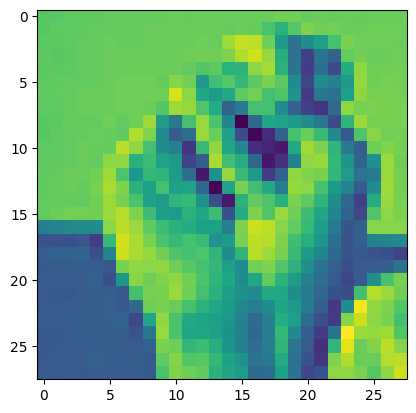

In [181]:
for i, j in train_data: 
  temp_img = i 

  plt.imshow(temp_img.permute(1,2,0))
  break

In [182]:
class SignLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(SignLabelModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = SignLabelModel(NUM_CLASS).to(device)

In [187]:
num_epochs = 20
criterion  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images.to(device))
        loss = criterion(outputs, labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")